#**XGBoost**
---
##Author: Emmanuel Paalam
##V5: MICEV2 processing
##Target variable: F3EVERDO

## Import data

In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# Load the transformed data
X_train = pd.read_csv('/content/drive/My Drive/research/SURP 2024/colab/data/processed/X_train_MICEimputed.csv')
X_test = pd.read_csv('/content/drive/My Drive/research/SURP 2024/colab/data/processed/X_test_MICEimputed.csv')
y_train = pd.read_csv('/content/drive/My Drive/research/SURP 2024/colab/data/processed/y_MICEtrain.csv')
y_test = pd.read_csv('/content/drive/My Drive/research/SURP 2024/colab/data/processed/y_MICEtest.csv')

print(f"{X_train.shape}, {X_test.shape}, {y_train.shape}, {y_test.shape}")

(10495, 211), (2624, 211), (10495, 1), (2624, 1)


##Apply SMOTE oversampling

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy=0.55, random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print(f"{X_train_balanced.shape}, {y_train_balanced.shape}")

(14596, 211), (14596, 1)


##Model development

In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

In [ ]:
param_grid = {
    'learning_rate': [0.05],
    'n_estimators': [75],
    'max_depth': [9],
    'min_child_weight': [1]
}

In [ ]:
def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

def npv_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fn)

In [ ]:
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, accuracy_score

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='macro'),
    'recall': make_scorer(recall_score, average='macro'),
    'f1': make_scorer(f1_score, average='macro'),
    'specificity': make_scorer(specificity_score),
    'npv': make_scorer(npv_score)
}

In [ ]:
from sklearn.model_selection import StratifiedKFold

grid_search = GridSearchCV(xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'), param_grid=param_grid,
                           scoring=scoring, refit='f1', cv=StratifiedKFold(n_splits=5), verbose=1, n_jobs=-1)

In [ ]:
grid_search.fit(X_train_balanced, y_train_balanced)

# Access and print the cv_results_
results = grid_search.cv_results_

Fitting 5 folds for each of 2 candidates, totalling 10 fits


In [ ]:
import numpy as np

# Print the relevant metrics
print("Mean Test Accuracy:", np.mean(results['mean_test_accuracy']))
print("Mean Test Precision:", np.mean(results['mean_test_precision']))
print("Mean Test Recall:", np.mean(results['mean_test_recall']))
print("Mean Test F1:", np.mean(results['mean_test_f1']))
print("Mean Test Specificity:", np.mean(results['mean_test_specificity']))
print("Mean Test NPV:", np.mean(results['mean_test_npv']))

Mean Test Accuracy: 0.9519120945904723
Mean Test Precision: 0.9575852988583331
Mean Test Recall: 0.9412045840139084
Mean Test F1: 0.9431155984907269
Mean Test Specificity: 0.978070015210403
Mean Test NPV: 0.9559836157152101


In [ ]:
# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best parameters found: ", best_params)
print("Best cross-validation score: {:.2f}".format(best_score))

Best parameters found:  {'learning_rate': 0.05, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 75}
Best cross-validation score: 0.94


### Observe metrics

Accuracy: 0.9504573170731707
Precision: 0.7868852459016393
Recall: 0.7111111111111111
F1 Score: 0.7470817120622567
ROC-AUC: 0.9624673526542685
Specificity: 0.9779099405267629
Test Negative Predictive Value (NPV): 0.9672268907563025
Confusion Matrix:
[[2302   52]
 [  78  192]]


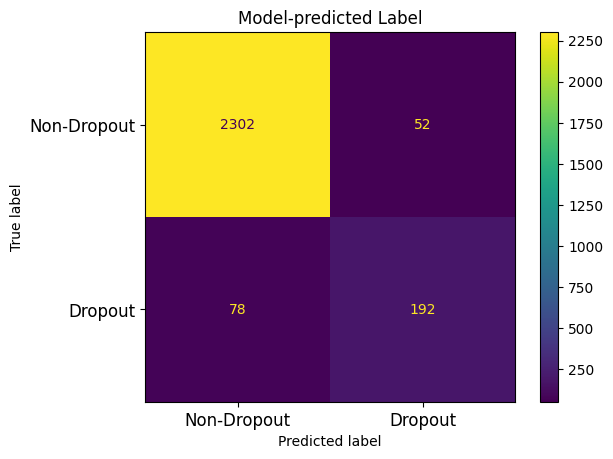

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay

# Retrieve the best model
best_model = grid_search.best_estimator_

# Predict on the test set
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Calculate specificity
tn, fp, fn, tp = conf_matrix.ravel()
specificity = tn / (tn + fp)

# Calculate test negative predictive value (NPV)
test_npv = tn / (tn + fn)

# Print the metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC-AUC: {roc_auc}")
print(f"Specificity: {specificity}")
print(f'Test Negative Predictive Value (NPV): {test_npv}')
print("Confusion Matrix:")
print(conf_matrix)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=best_model.classes_)
disp.plot()

tick_labels = ['Non-Dropout', 'Dropout']
plt.xticks(ticks=[0, 1], labels=tick_labels, fontsize=12)
plt.yticks(ticks=[0, 1], labels=tick_labels, fontsize=12)
plt.title('Model-predicted Label', fontsize=12)

plt.show()

<ipython-input-26-24ad0af52676>:17: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.plot([0, 1], [positive_ratio, positive_ratio], 'k--', lw=2, label='Baseline (Proportion of Dropouts = %0.2f)' % positive_ratio)


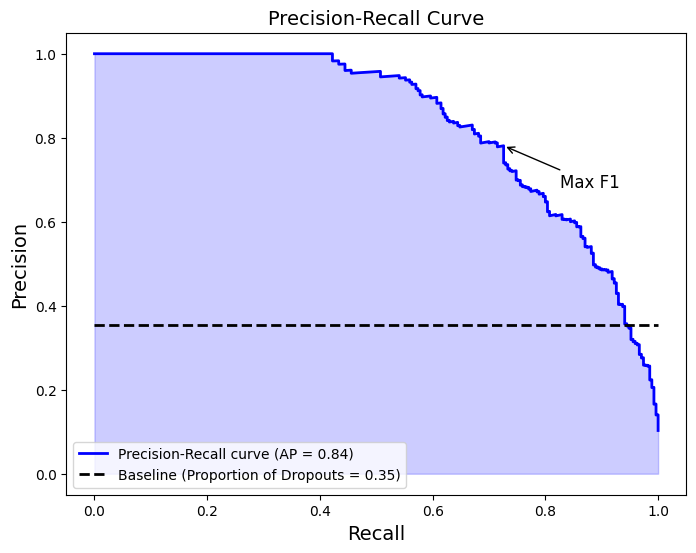

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Compute precision-recall curve and average precision
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
average_precision = average_precision_score(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (AP = %0.2f)' % average_precision)

# Shade the area under the curve
plt.fill_between(recall, precision, alpha=0.2, color='blue')

# Calculate the baseline (proportion of positives)
positive_ratio = np.sum(y_train_balanced) / len(y_train_balanced)
# Add a baseline
plt.plot([0, 1], [positive_ratio, positive_ratio], 'k--', lw=2, label='Baseline (Proportion of Dropouts = %0.2f)' % positive_ratio)

# Annotate a key point
max_f1_idx = np.argmax(2 * (precision * recall) / (precision + recall))
plt.annotate('Max F1', xy=(recall[max_f1_idx], precision[max_f1_idx]), xytext=(recall[max_f1_idx] + 0.1, precision[max_f1_idx] - 0.1),
             arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=12)

plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('Precision-Recall Curve', fontsize=14)
plt.legend(loc="lower left")
plt.show()